In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 1.데이터

## - 데이터 살펴보기

In [6]:
bike_df=pd.read_csv('./bikesharingdemand/train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [7]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## - 데이터 수정하기

In [14]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

#년, 월, 일, 시간 을 따로 빼내어 feature로 만들기
bike_df['year'] = bike_df['datetime'].apply(lambda x:x.year)
bike_df['month'] = bike_df['datetime'].apply(lambda x:x.month)
bike_df['day'] = bike_df['datetime'].apply(lambda x:x.day)
bike_df['hour'] = bike_df['datetime'].apply(lambda x:x.hour)

bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


* 데이터 중 버릴 항목 정하기

In [17]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

# 2.성능평가함수 작성하기
kaggle에서의 성능평가방법은 RMSLE(Root Mean Square Log Error)이기 때문에 이를 계산하는 함수를 직접 구현

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y-log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE:{0:.3f}, RMSE:{1:.3f}, MAE:{2:.3f}'.format(rmsle_val, rmse_val, mae_val))

# 3. 간단한 모델을 적용해 결과를 확인하면서, 
# 데이터가 정규분포인지, 원핫인코딩을 해줘야하는지 여부를 판단

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE:1.165, RMSE:140.900, MAE:105.924


* `예측 오류값이 너무 큼.`
```
이 경우, 실제 값과 차이가 어느 정도인지를 보기 위해 예측값과 실제값을 한번 살펴보기로한다.
```

In [27]:
def top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['실제값'])
    result_df['예측값'] = np.round(pred)
    result_df['차이']=np.abs(result_df['실제값']-result_df['예측값'])
    print(result_df.sort_values('예측값', ascending=False)[:n_tops])

top_error_data(y_test, pred, n_tops=5)

      실제값    예측값     차이
2000  277  464.0  187.0
2487  287  463.0  176.0
2199  201  459.0  258.0
582   427  456.0   29.0
1690  547  456.0   91.0


* `실제값과 예측값과의 차이가 매우 큰 편이다.`
```
이 경우, 가장 먼저 Target 값의 분포가 왜곡된형태를 이루고 있지는 않은지 확인해봐야한다.
```

<Axes: >

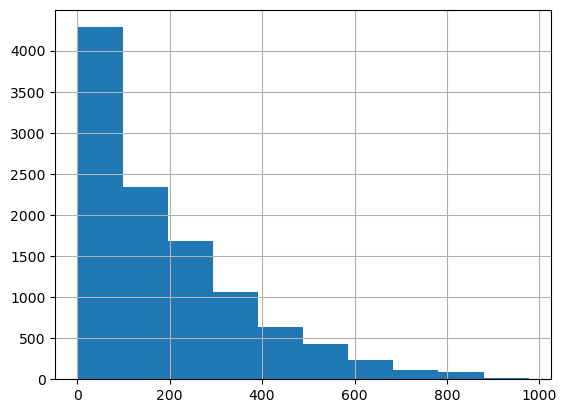

In [28]:
y_target.hist()

```
count 칼럼(target)값이 정규분포를 이루고 있지 않고, 0~200 사이에 왜곡되어있음을 확인하였다.
이제 이를 정규분포 형태로 바꾸어보자. 이때 바꾼 값을 다시 원래의 값으로 바꾸기 위해서는 expm1() 함수를 적용하면 된다.
```

<Axes: >

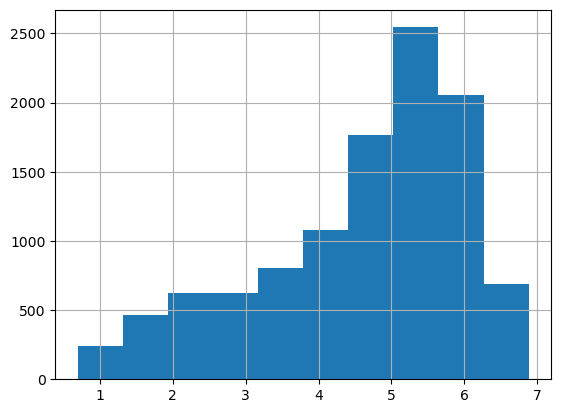

In [29]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

```
완벽한 정규분포의 모습은 아니지만 어느정도 정규분포의 모습을 보이니 다시한번 학습을 진행해보자.
```

In [31]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#실제값과 예측값 모두 실제 값에 log1p가 되었으므로 다시 원복하기 위해 다음이 필요하다.
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE:1.017, RMSE:162.594, MAE:109.286


* `RMSLE 오류는 줄었지만, RMSE 오류는 오히려 더 늘어남.`
```
이 경우, 각 피처의 회귀 계수 값을 눈으로 직접 확인한다.
이때 큰 특징계수를 가지는 feature를 의심해보고 이렇게 큰 영향을 가질 수 있는지 생각해본다.
단지 숫자가 다른 feature보다 커 큰 영향을 미치고 있는 것은 아닌지 생각해보아야한다.
```

<Axes: >

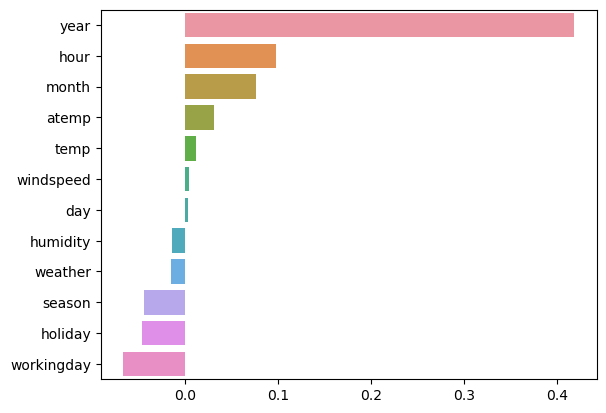

In [32]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

```
year 피처의 회귀계수값이 독보적으로 큰 값을 가진다. 
year는 2011, 2012 년 두개의 값을 가지는데 자전거 대여횟수에 영향을 크게 준다는 것을 납득하기 어려움.
이렇게 선형회귀 방식에 숫자형 카테고리 값을 사용할 경우, 숫자형 값의 크기에 영향을 받는 경우가 발생할 수 있다.
따라서 이 경우, 원핫인코딩 방식을 적용한 후 다시 예측해보아야한다.
```

In [34]:
#원핫인코딩 적용
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday','season','weather'])
X_features_ohe.head(3)

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
1,9.02,13.635,80,0.0,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
2,9.02,13.635,80,0.0,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False


다시 예측해보기

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('### ',model.__class__.__name__,' ###')
    evaluate_regr(y_test, pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, True)

###  LinearRegression  ###
RMSLE:0.590, RMSE:97.687, MAE:63.382
###  Ridge  ###
RMSLE:0.590, RMSE:98.529, MAE:63.893
###  Lasso  ###
RMSLE:0.635, RMSE:113.219, MAE:72.803


원핫인코딩 적용 후 예측 성능이 눈에 띄게 좋아짐.

* 원핫인코딩 적용 후 회귀계수가 높은 피처를 다시 시각화해보자.

<Axes: >

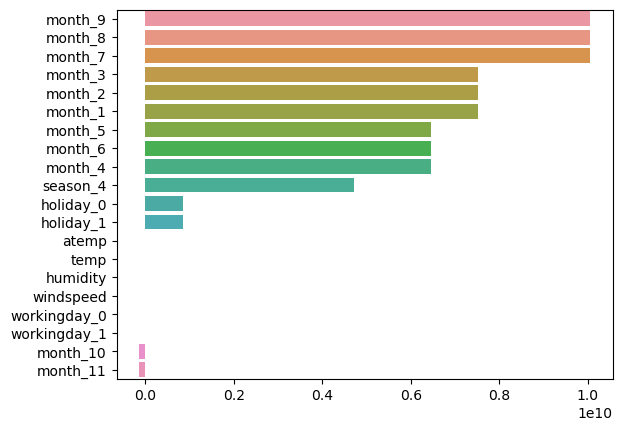

In [37]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

확인 결과, 자전거의 대여횟수는 월과 계절, 주말 여부에 관계가 깊음을 확인할 수 있다.

# 4. 다른 모델에 적용해보기
* 랜덤포레스트
* GBM
* XGBOOST
* LIGHTGBM

In [39]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor

# 각 모델별로 평가수행
rf_ref = RandomForestRegressor(n_estimators=500)
gbm_ref = GradientBoostingRegressor(n_estimators=500)
xgb_ref = XGBRFRegressor(n_estimators=500)
lgbm_ref = LGBMRegressor(n_estimators=500)

for model in [rf_ref, gbm_ref, xgb_ref, lgbm_ref]:
    #XGBOOST의 경우, dataframe이 입력될 경우, 버전에 따라 오류가 발생하므로 ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

###  RandomForestRegressor  ###
RMSLE:0.354, RMSE:50.122, MAE:31.091
###  GradientBoostingRegressor  ###
RMSLE:0.330, RMSE:53.346, MAE:32.745
###  XGBRFRegressor  ###
RMSLE:0.776, RMSE:156.142, MAE:98.854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
###  LGBMRegressor  ###
RMSLE:0.319, RMSE:47.215, MAE:29.029


```
트리회귀 모델들이 선형회귀 모델보다 더 나은 성능을 내놓았다.
이 경우, 착각하면 안되는게 단순히 트리회귀가 선형회귀보다 좋다는 것이 아니라 데이터세트의 유형에 따라 결과는 얼마든지 달라질 수 있음에 유념하여야한다.
```